# Percentile results
This notebook reflects the results obtained for the psycho network

In [6]:
import sys, os
sys.path.insert(0, '../')
from matplotlib import style
style.use('seaborn-poster')

import matplotlib.pyplot as plt, numpy as np, networkx as nx
from Utils.stats import driverNodeEstimate
from Utils import IO

# fn = 'tester.pickle'
fn = '../data2019-11-24T11:30:04.533109.pickle'
for k, v in IO.loadPickle(fn).items():
    print(f'Loading {k}')
    globals()[k] = v

s = next(iter(settings))
setting = settings[s]
centralities = dict(\
                   degree = nx.degree_centrality,\
                   betweenness = nx.betweenness_centrality,\
                   closeness  = nx.closeness_centrality,\
                   eigenvector = nx.eigenvector_centrality,\
                   )

Loading aucs
Loading data
Loading rdata
Loading settings
Loading coeffs


In [28]:
%load_ext autoreload
%autoreload 2
DRIVERS = {}
alpha = .01
from tqdm import tqdm_notebook as tqdm
from Utils.stats import bootStrapDrivers
N, n = int(1e4), 20

N = int(1e4)

# for all aucs

# from Utils.stats import bootStrapThresholds
alphas = np.linspace(0.1, 1, 10)
alphas  = np.array([0, .05])
structuralData = {}
for k, setting in settings.items():
    m = setting.get('model')
    g = m.graph
    
    buffer = np.zeros((m.nNodes))
    centData = {}
    for condition, cf in centralities.items():
        c = cf(g)
        for node, val in c.items():
            idx = m.mapping[node]
            buffer[idx] = val
        MAX = buffer.max()
        cdrivers = np.where(buffer == MAX)[0]
#         print(cdrivers, np.where(buffer == MAX))
        print(cdrivers)
        centData[condition] = cdrivers
    structuralData[k] = centData
    
from Utils.stats import returnX
from itertools import product


from Utils.stats import bootStrapAll
boots = {}
alldrivers = {}
total = int(1e5)
batch = 20
alpha = .5
for k, v in aucs.items():
    v = np.moveaxis(v, 0, 1) # swap trials and nodes
    print(k, v.shape)
    alldrivers[k] = bootStrapAll(v, returnX, total, batch, alpha)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
[0]
[9]
[0]
[0]
Data/stupid/2019-11-20T11:48:39.216356 (20, 12, 6, 3)


In [36]:
from Utils.stats import computeMatchScore
conditions = len(centralities) + 1

for k, v in alldrivers.items():
    setting = settings.get(k)
    pulses = np.array (setting.get('pulseSizes') )
   
    s = v.shape[:-1]
    npulse, ntemps = s
    tmp = np.array([list(i.keys()) for i in v[...,0].flat], dtype = dict).reshape(s)
    
    ti = np.array([i for i in structuralData[k].values()], dtype = list)
    
    d = np.zeros((conditions + 1, pulses.size, ntemps), dtype = list)
    # print('>', tmp.shape, v.shape)
    d[0] = tmp[1:]
    d[1] = tmp[0]
#     print(d)
#     print(d.shape)
    
    
    s = d.shape
    d = d.reshape(conditions + 1, -1)
    d[2:] = ti
    d = d.reshape(s)
    
    d = d.reshape(-1)
    driverSizes = np.zeros(d.shape)
    for idx, i in enumerate (d):
        try:
            iter(i)
        except:
            d[idx] = [i]
        driverSizes[idx] = len(d[idx])
        
    d = d.reshape(s)
    driverSizes = driverSizes.reshape(s)
#     print(ti, tmp.shape)
    overlap = computeMatchScore(d)

print('>>', overlap.shape)

>> (6, 5, 3)


(6, 5, 3)


<ipython-input-30-94abf512ca3f>:34: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


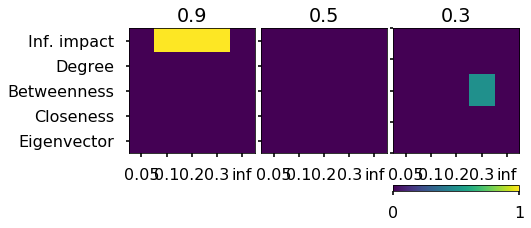

In [30]:
conditions, npulse, ntemps = overlap.shape
print(overlap.shape)
# show jaccard scores

hr = np.ones(3)
hr[-2] = .1
hr[-1] = .05
gs = dict(height_ratios = hr)
fig, ax = plt.subplots(3, ntemps, sharey = 'row',\
                       figsize = (7,3),\
                      gridspec_kw = gs)

yr = np.arange(conditions - 1)
cLabels = ['Inf. impact', *[i.capitalize() for i in centralities.keys()]]

ratios = setting.get('equilibrium').get('ratios').keys()
ratios = list(ratios)
for tidx, axi in enumerate(ax[0]):
    h = axi.imshow(overlap[1:, :, tidx], aspect = 'auto', vmin = 0, vmax = 1)
    xr = np.arange(pulses.size)
    axi.set_xticks(xr)
    axi.set_xticklabels(pulses)
    axi.set_yticks(yr)
    axi.set_yticklabels(cLabels)
    axi.set_title(ratios[tidx])
for axi in ax[1:].flat:
    axi.axis('off')
    
axi.axis('on')
axi.set_xlim(0, 1)
fig.colorbar(h, cax = axi, orientation = 'horizontal', ticks = (0, 1))
fig.subplots_adjust(wspace = .05)
fig.savefig('pyscho_jaccard.svg')
fig.show()

(6, 5, 3)
(6, 3)


<ipython-input-31-3aaeb1aac38f>:62: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


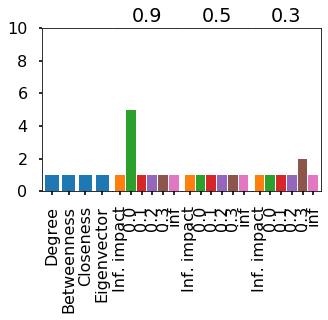

In [31]:
# plot driver sizes
conditions, npulse, ntemps = driverSizes.shape
print(driverSizes.shape)

# wr = np.ones(ntemps + 1)
# wr[1] = .1
# gs = dict(width_ratios = wr)
fig, ax = plt.subplots(1, ntemps + 1,\
#                       gridspec_kw = gs,\
                      figsize = (5, 3))
ax[0].bar(np.arange(conditions - 2), driverSizes[2:, 0, 0])
ax[0].set_ylim(0, 10)
ax[0].spines['right'].set_visible(0)
ax[0].set_xticks(np.arange(len(cLabels[:-1])))
ax[0].set_xticklabels(cLabels[1:], rotation = 90)




tmpSizes = np.zeros((npulse + 1, ntemps))
tmpSizes[1:] = driverSizes[0]
tmpSizes[0]  = driverSizes[1, 0]


# width = 1/len(tmpSizes.T)
width = 1/5

print(tmpSizes.shape)
xr = np.arange(0, 5) / width

dLabels = ['Inf. impact', *pulses.round(1)]
colors = plt.cm.tab10(range(len(tmpSizes) + 1))
for idx, axi in enumerate(ax[1:]):
    
    d = tmpSizes[..., idx]
#     print(d.shape)
    
    xr = []
    for jdx, di in enumerate(d):
#         print(jdx)
        xr.append(width * jdx)
        axi.bar(width * jdx,\
                height = di, width = .9 * width, \
                color = colors[jdx + 1])
#     axi.set_xticks(xr)
#     axi.set_xticklabels(dLabels, rotation = 90)
    axi.set_ylim(0, 10)
    axi.set_yticks([])
    axi.set_xticks(xr)
    axi.set_xticklabels(dLabels, rotation = 90)
    axi.spines['left'].set_visible(0)
    axi.set_title(ratios[idx])
    if idx < ntemps - 1:
        axi.spines['right'].set_visible(0)
#     axi.bar(np.arange(2), height = driverSizes[:2, ..., tidx], aspect = 'auto')
    if idx > 0:
        axi.set_yticklabels([])
#     axi.set_yticklabels(labels)
#     axi.set_xticklabels(pulses)
fig.subplots_adjust(wspace = 0)
fig.savefig('pyscho_driver.svg')
fig.show()


# boostrap results

In [32]:
# perform boostrap
tmp = overlap[1:]
tmp = np.moveaxis(tmp, 1, -1)
tmp = np.moveaxis(tmp, 0, 1)

ntemps, npulse, nconditions = tmp.shape
print(tmp.shape)
tmp = tmp.reshape(-1, nconditions)
tmp += 1e-3
from Utils.stats import bootStrap, ratio
boots = bootStrap(tmp, \
                  total = N, \
                  func = ratio,\
                  batch = len(tmp))

(3, 5, 5)


(10000, 4)
0
0.004448743783816155 0.9317282717282717
1
0.004448743783816155 0.9317282717282717
2
0.0077218131528816215 0.8642498951480988
3


<ipython-input-33-c0121c5be328>:23: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


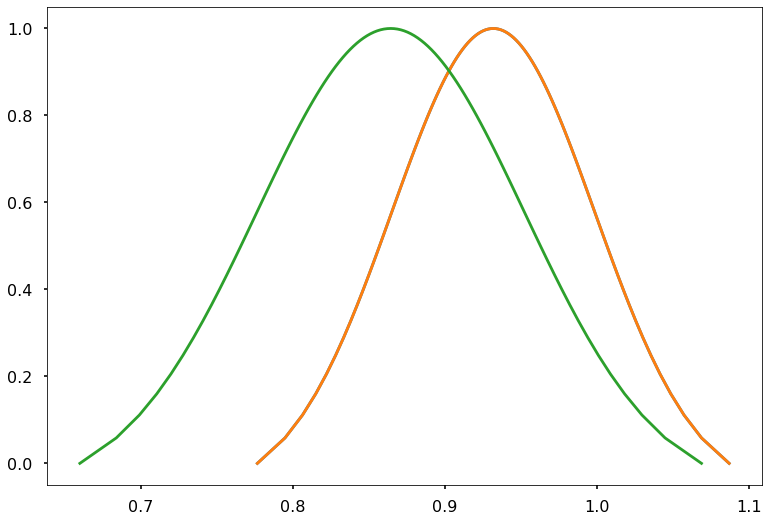

In [33]:
from statistics import NormalDist
theta = 1
thetas = [theta, 100-theta]
fig, ax = plt.subplots()
print(boots.shape)

# ax.imshow(boots, aspect = 'auto')
for idx, i in enumerate(boots.T):
    print(idx)
    try:
        dist = NormalDist().from_samples(i)
    #     dist.quantile()

        quants = dist.quantiles(100)
        print(dist.variance, dist.mean)
    #     print(quants, i)
    #     xr = np.linspace(left, right)
        y =  np.array([dist.pdf(q) for q in quants])
        y = (y - y.min()) / (y.max() - y.min())
        ax.plot(quants, y)
    except:
        continue
fig.show()

In [38]:
# get dataa
from scipy.stats import sem
tmp = np.array([i for i in rdata.values()]).squeeze()

nodes, ntrials, npulse, ntemps, deltas = tmp.shape

gs = dict()
%matplotlib widget
fig, ax = plt.subplots(npulse, ntemps, gridspec_kw = gs, \
                      figsize = (5, 5),\
                       sharex = 'all', sharey = 'col')

print(tmp.shape)
colors = plt.cm.tab20(range(nodes))
xr = np.arange(deltas)
for p in range(npulse):
    for t in range(ntemps):
        axi = ax[p, t]
        d = tmp.mean(1)[..., p, t, :]
        e = sem(tmp, 1)[..., p, t, :]
        for node in range(nodes):
            axi.errorbar(xr, d[node], yerr = 2 * e[node], color = colors[node])
        if t > 0:
            axi.set_yticklabels([])
        axi.set_ylim(0, 1.2)
#         axi.set_xlim(0, 5)
        if t == ntemps - 1 and p > 0:
            axi.annotate(pulses.round(2)[p - 1], (.9, .5), textcoords = 'axes fraction', \
                        horizontalalignment = 'right', fontsize = 20)
fig.subplots_adjust(wspace = 0,  hspace = 0.13)
fig.savefig('pyscho_time.svg')
fig.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

(12, 20, 6, 3, 14)


<ipython-input-38-5ea90d7eed58>:28: UserWarning: You have used the `textcoords` kwarg, but not the `xytext` kwarg.  This can lead to surprising results.
  axi.annotate(pulses.round(2)[p - 1], (.9, .5), textcoords = 'axes fraction', \


In [218]:

plt.close('all')
# hr = np.ones(3)

# Time data widget

In [25]:

import ipywidgets as widgets
from scipy.stats import sem
from Utils.plotting import addGraphPretty
# dataSlider = widgets.SelectionSlider(options = data.keys())
dataSlider = widgets.Select(options = data.keys())
tempSlider = widgets.IntSlider(min = 0, max = 2)

print(npulse)
pulseSlider = widgets.IntSlider(min = 1, max = npulse)


%matplotlib notebook
fig, (left, right) = plt.subplots(1, 2, figsize = (10, 7), sharey = 'all')
mainax = fig.add_subplot(111, frameon = 0,\
                        xticks = [],\
                        yticks = [])
mainax.set_xlabel('Time[step]', labelpad = 30)
# inax.axis('off')
@widgets.interact(dataName = dataSlider, \
                  temp = tempSlider, \
                  pulse = pulseSlider)
def update(dataName, temp, pulse):
    d = rdata.get(dataName)
    
    for idx, i in enumerate(data.keys()):
        if i == dataName:
            break
    print(alldrivers[dataName].shape)
    a = aucs.get(dataName)[..., pulse, temp].mean(1)
    print(a, aucs[dataName].shape)
    drivers = alldrivers[dataName][pulse, temp, 0]
    print(drivers)
    mainax.set_title(dataName + "\n" + str(drivers.keys()))
    g = settings.get(dataName).get('graph')

    
    nodes, trials, pulses, temps, deltas = d.shape
    colors = plt.cm.tab20(range(nodes))
    means = d.mean(1)
    sems  =  2 * np.std(d, axis = 1)
    xr = np.arange(d.shape[-1])
    
    left.cla(); right.cla()
    
    inax = right.inset_axes([.4, 0.4, .6, .6])
    addGraphPretty(g, ax = inax)
    inax.axis('off')
    for node in range(nodes):
        left.errorbar(xr, means[node, 0, temp], \
                      sems[node, 0, temp], \
                      color = colors[node],\
                      label = node)
        right.errorbar(xr, means[node, pulse, temp], \
                       sems[node, pulse, temp], \
                       color = colors[node],\
                       label = node)
#         left.set_yscale('log')
#         right.set_yscale('log')
    
    elems = [\
             plt.Line2D([], [], color = colors[node], \
                  label = f'{node}{"*" if node in drivers else ""}', \
                  marker = 'o', linestyle = 'None')\
                  for node in range(nodes)\
          ]
    left.set_ylabel(r'$I(s_i^{t_0 + t} ; S^{t_0})$')
    right.set_ylabel(r"$D_{KL}(P' \vert \vert P)$")
    right.legend(handles = elems, \
                 bbox_to_anchor = (1.0, 1), loc = 'upper left',\
                title = 'Node', title_fontsize = 20,\
                frameon = 0,\
                borderaxespad = 0)
fig.show(0)

4


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

interactive(children=(Select(description='dataName', options=('Data/psycho/2019-11-18T13:46:57.312796',), valu…

In [23]:
tmp = next(iter(rdata.values())).mean(1)[..., 1, 0,:]
tmp = abs(np.diff(tmp, axis = 1).mean(1))
print(tmp
     )
tmp[np.argwhere(tmp < .01)] = 0
# tmp = np.sort(abs(tmp))
fig, ax = plt.subplots()
ax.plot(tmp)
print(np.percentile(abs(tmp), 90), tmp)
# print(tmp.mean(1))



[0.00081211 0.00223881 0.07561266 0.00092398 0.00098897 0.00062697
 0.0001304  0.00060335 0.00090773 0.00012403 0.01651107 0.03018443]


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

0.02881708991132045 [0.         0.         0.07561266 0.         0.         0.
 0.         0.         0.         0.         0.01651107 0.03018443]


In [51]:
for dir in os.listdir('../Data'):
    try:
        s = IO.loadPickle(f'../Data/{dir}/settings.pickle')
        print(dir, s.get('modelSettings'), s.get('graph').number_of_nodes())
    except:
        continue
# s = IO.loadPickle('../Data/settings.pickle')
# m = s.get('model')(s.get('graph'))
# m.nNodes

2019-10-28T00:23:27.649748 {'magSide': '', 'updateType': '0.25', 'nudgeType': 'constant'} 30
2019-11-20T15:23:33.819422 {'magSide': '', 'updateType': '0.5', 'nudgeType': 'constant'} 12
2019-11-06T15:20:18.891135 {'magSide': '', 'updateType': '0.25', 'nudgeType': 'constant'} 12
2019-11-10T10:27:25.105002 {'magSide': '', 'updateType': '0.25', 'nudgeType': 'constant'} 12
2019-11-18T13:46:57.312796 {'magSide': 'neg', 'updateType': '0.5', 'nudgeType': 'constant'} 12
2019-10-28T00:23:23.647182 {'magSide': '', 'updateType': '0.25', 'nudgeType': 'constant'} 30
2019-11-17T12:25:12.527499 {'magSide': '', 'updateType': '0.5', 'nudgeType': 'constant'} 12
2019-11-18T09:48:58.046043 {'magSide': 'neg', 'updateType': '0.5', 'nudgeType': 'constant'} 12
2019-11-07T07:50:30.106371 {'magSide': '', 'updateType': '0.25', 'nudgeType': 'constant'} 12
2019-10-31T14:33:34.823116 {'magSide': '', 'updateType': '0.25', 'nudgeType': 'constant'} 12
2019-11-17T16:47:08.626152 {'magSide': '', 'updateType': '0.5', 'nud